In [1]:
#!pip install imbalanced-learn
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, roc_curve, roc_auc_score, auc, confusion_matrix, precision_score, pairwise
import imblearn

import matplotlib.pyplot as plt
import math

In [2]:
# importing the features normalised and dropping all the non relevant columns to have a clean start
df = pd.read_csv("../data/processed/ISIC_2017_norm_features.csv")
df = df.drop(["seborrheic_keratosis", "Perimeter", "Area", "image_id", "Red", "Green", "Blue"], axis=1)

df.head()
#Note: for sex, 1 is female, 0 is male

,melanoma,Norm_Compactness,Norm_Asymmetry,Norm_Average Color,Norm_Age,Sex
0,0.0,0.434213,0.565848,0.512858,0.647059,1
1,0.0,0.079822,0.714482,0.513188,0.352941,1
2,1.0,0.312995,0.818309,0.657999,0.705882,1
3,0.0,0.346936,0.747794,0.628721,0.352941,0
4,1.0,0.381283,0.671515,0.458960,0.941176,0


In [3]:
# Split the data before feature selection
from sklearn.model_selection import train_test_split

#copying the dataframe. it should be with .copy() but it works like this too
df2 = df.copy()


# Some noisy features
noise = np.random.RandomState(42).uniform(0, 0.1, size=(df2.shape[0], 20))

# Add the noisy data to the informative features
# this is not something that makes sense to me. we add the noise to then ignore it in the next cell
X = np.hstack((df2[['Norm_Compactness', 'Norm_Asymmetry', "Norm_Average Color"]], noise))
y = df2['melanoma'].astype("int32")

# Split dataset to select feature and evaluate the classifier
# the splitting is done by splitting the data into data to be used for training and validation (development of the model --> dev), and data to be used for testing. 
X_dev, X_test, y_dev, y_test = train_test_split(
        X, y, stratify=y)

# the development data is split into training and validation.
X_train, X_val, y_train, y_val = train_test_split(
        X_dev, y_dev, stratify=y_dev)

In [4]:
# Train a classifier
X_train = X_train[:,0:3] # Take only wanted features
roc_dict = {}
knn_list = [None]

neigh = int(math.sqrt(len(X_train)))
neigh
# the range is to the neigh, as some sources suggest to use the square root of the number of datapoints, and it does seem as a fair estimation to decrease error
for i in range(1, neigh+1):
    #train the model with different values of the neighbors
    knn1 = KNeighborsClassifier(n_neighbors=i) 
    knn1trained = knn1.fit(X_train, y_train)
    
    #Select the same features as before
    X_val = X_val[:, 0:3]
    y_val_knn1 = knn1trained.predict_proba(X_val)
    
    #adding the roc_score value to the dictionary to assess which is the best
    # can be calculated with another calculation, but it would be time consuming to do both to show they are identical
    fpr, tpr, threshold = roc_curve(y_val, y_val_knn1[:,1])
    roc_test = auc(fpr,tpr)
    roc_dict[i] = roc_test
    knn_list.append(knn1trained)


# getting all the values with the highest accuracy score
max_keys = [key for key, value in roc_dict.items() if value == max(roc_dict.values())]

# we use the biggest of the neighbors values as the neighbor to use for the classification, as a lower value is not recomended 
print(roc_dict[max_keys[-1]])

#best trained knn algorithm
final_knn_trained = knn_list[max_keys[-1]]
y_val_knn1 = knn1trained.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, y_val_knn1[:,1])
roc_test = auc(fpr,tpr)



print(max_keys[-1])
print(roc_auc_score(y_val, final_knn_trained.predict(X_val)), roc_test)

0.592599531615925
8
0.5033957845433256 0.574192037470726


In [5]:
# Train a classifier
X_train = X_train[:,0:3] # Take only wanted features
roc_dict = {}


neigh = int(math.sqrt(len(X_train)))
neigh
# the range is to the neigh, as some sources suggest to use the square root of the number of datapoints, and it does seem as a fair estimation to decrease error
for i in range(1, neigh+1):
    #train the model with different values of the neighbors
    tree1 = DecisionTreeClassifier() 
    tree1trained = tree1.fit(X_train, y_train)
    
    #Select the same features as before
    X_val = X_val[:, 0:3]
    y_val_tree1 = tree1trained.predict(X_val)
    
    #adding the accuracy value to the dictionary to assess which is the best
    # can be calculated with another calculation, but it would be time consuming to do both to show they are identical
    roc_test = roc_auc_score(y_val, y_val_tree1)
    roc_dict[i] = roc_test


# getting all the values with the highest accuracy score
max_keys = [key for key, value in roc_dict.items() if value == max(roc_dict.values())]

# we use the biggest of the neighbors values as the neighbor to use for the classification, as a lower value is not recomended 
print(roc_dict[max_keys[-1]])
print(roc_dict)

0.5330210772833723
{1: 0.5269320843091335, 2: 0.5203747072599532, 3: 0.5110070257611241, 4: 0.5214285714285715, 5: 0.5242388758782202, 6: 0.5285714285714286, 7: 0.5330210772833723, 8: 0.507728337236534, 9: 0.5148711943793911, 10: 0.5230679156908665, 11: 0.5170960187353629, 12: 0.5060889929742389, 13: 0.5044496487119439, 14: 0.509367681498829, 15: 0.4989461358313817, 16: 0.5220140515222482, 17: 0.511592505854801, 18: 0.5126463700234192, 19: 0.507728337236534, 20: 0.5181498829039813, 21: 0.5220140515222482, 22: 0.5060889929742389, 23: 0.528103044496487, 24: 0.5187353629976581, 25: 0.5110070257611241, 26: 0.5291569086651053, 27: 0.5126463700234192, 28: 0.5126463700234192, 29: 0.5313817330210773, 30: 0.5187353629976581, 31: 0.5060889929742389, 32: 0.5187353629976581, 33: 0.5148711943793911}


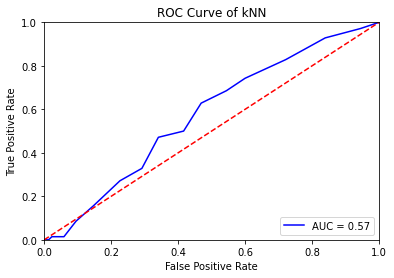

[[0.90909091 0.09090909]
 [0.93939394 0.06060606]
 [0.75757576 0.24242424]
 [0.78787879 0.21212121]
 [0.96969697 0.03030303]
 [0.66666667 0.33333333]
 [0.75757576 0.24242424]
 [0.93939394 0.06060606]
 [0.90909091 0.09090909]
 [0.96969697 0.03030303]
 [0.84848485 0.15151515]
 [0.66666667 0.33333333]
 [0.63636364 0.36363636]
 [0.93939394 0.06060606]
 [0.84848485 0.15151515]
 [0.90909091 0.09090909]
 [0.90909091 0.09090909]
 [0.66666667 0.33333333]
 [1.         0.        ]
 [0.6969697  0.3030303 ]
 [0.6969697  0.3030303 ]
 [0.6969697  0.3030303 ]
 [0.93939394 0.06060606]
 [0.63636364 0.36363636]
 [0.75757576 0.24242424]
 [0.66666667 0.33333333]
 [0.75757576 0.24242424]
 [0.96969697 0.03030303]
 [0.6969697  0.3030303 ]
 [0.6969697  0.3030303 ]
 [0.87878788 0.12121212]
 [0.96969697 0.03030303]
 [0.81818182 0.18181818]
 [0.6969697  0.3030303 ]
 [0.63636364 0.36363636]
 [0.63636364 0.36363636]
 [0.66666667 0.33333333]
 [0.72727273 0.27272727]
 [0.93939394 0.06060606]
 [0.96969697 0.03030303]


In [6]:
y_scores = knn1trained.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, y_scores[:, 1])
roc_auc = auc(fpr, tpr)

plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.title('ROC Curve of kNN')
plt.show()
print(y_scores)

In [7]:
y_val_knn1 = knn1trained.predict_proba(X_val)
fpr, tpr, threshold = roc_curve(y_val, y_val_knn1[:, 1])
roc_auc = auc(fpr, tpr)
print(roc_auc)
y_val_knn1

0.574192037470726


array([[0.90909091, 0.09090909],
       [0.93939394, 0.06060606],
       [0.75757576, 0.24242424],
       [0.78787879, 0.21212121],
       [0.96969697, 0.03030303],
       [0.66666667, 0.33333333],
       [0.75757576, 0.24242424],
       [0.93939394, 0.06060606],
       [0.90909091, 0.09090909],
       [0.96969697, 0.03030303],
       [0.84848485, 0.15151515],
       [0.66666667, 0.33333333],
       [0.63636364, 0.36363636],
       [0.93939394, 0.06060606],
       [0.84848485, 0.15151515],
       [0.90909091, 0.09090909],
       [0.90909091, 0.09090909],
       [0.66666667, 0.33333333],
       [1.        , 0.        ],
       [0.6969697 , 0.3030303 ],
       [0.6969697 , 0.3030303 ],
       [0.6969697 , 0.3030303 ],
       [0.93939394, 0.06060606],
       [0.63636364, 0.36363636],
       [0.75757576, 0.24242424],
       [0.66666667, 0.33333333],
       [0.75757576, 0.24242424],
       [0.96969697, 0.03030303],
       [0.6969697 , 0.3030303 ],
       [0.6969697 , 0.3030303 ],
       [0.

In [ ]:

tn, fp, fn, tp = (confusion_matrix(y_val,knn1trained.predict(X_val))).ravel()
print(tn,fp,fn,tp)

In [ ]:
knn1trained.predict_proba(X_val)

In [ ]:
precision_score(y_val,final_knn_trained.predict(X_val))

In [ ]:
np.unique(y_val,return_counts= True)